In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cloudburst/cloudpredictionsystemproject.csv


In [2]:
file_path = '/kaggle/input/cloudburst/cloudpredictionsystemproject.csv' # Paste the path from the output above

# 2. Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# 3. Display the first 5 rows of the DataFrame to check it
print("\nSuccessfully loaded the data. Here are the first 5 rows:")
print(df.head())


Successfully loaded the data. Here are the first 5 rows:
         Date Location  MinimumTemperature  MaximumTemperature  Rainfall  \
0  01-12-2008   Albury                13.4                22.9       0.6   
1  02-12-2008   Albury                 7.4                25.1       0.0   
2  03-12-2008   Albury                12.9                25.7       0.0   
3  04-12-2008   Albury                 9.2                28.0       0.0   
4  05-12-2008   Albury                17.5                32.3       1.0   

   Evaporation  Sunshine WindGustDirection  WindGustSpeed WindDirection9am  \
0          NaN       NaN                 W           44.0                W   
1          NaN       NaN               WNW           44.0              NNW   
2          NaN       NaN               WSW           46.0                W   
3          NaN       NaN                NE           24.0               SE   
4          NaN       NaN                 W           41.0              ENE   

   ... Humidity9

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

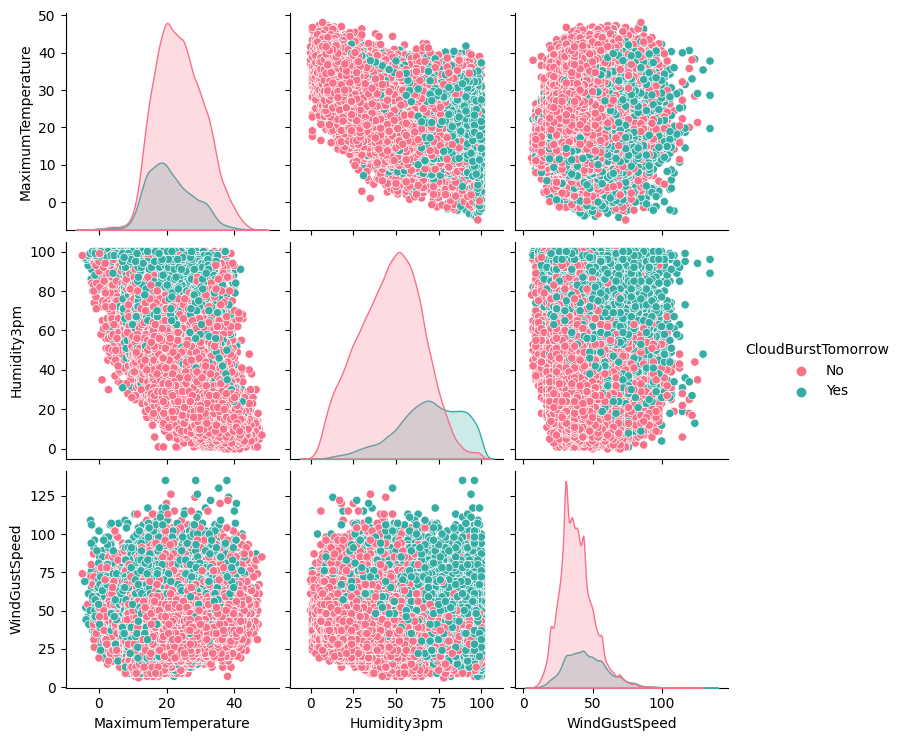

In [4]:
# Select a few important columns to plot
import matplotlib.pyplot as plt
import seaborn as sns
important_features = ['MaximumTemperature', 'Humidity3pm', 'WindGustSpeed', 'CloudBurstTomorrow']

sns.pairplot(df[important_features], hue='CloudBurstTomorrow', palette='husl')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88     22064
           1       0.57      0.77      0.66      6375

    accuracy                           0.82     28439
   macro avg       0.75      0.80      0.77     28439
weighted avg       0.85      0.82      0.83     28439


Confusion Matrix:


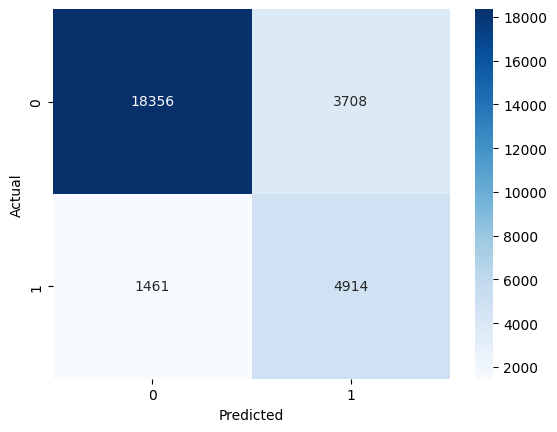

In [13]:
'''
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# --- 2. Data Cleaning & Preprocessing ---

# Step 2a: Handle the target variable nulls (CRITICAL)
df.dropna(subset=['CloudBurstTomorrow'], inplace=True)

# Step 2b: Drop columns with too many missing values
# While XGBoost can handle NaNs, it's better to remove columns that are mostly empty
df.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'], inplace=True)

# Step 2c: Convert binary 'Yes'/'No' columns to 1/0
df['CloudBurstTomorrow'] = df['CloudBurstTomorrow'].map({'No': 0, 'Yes': 1})
if 'CloudBurst Today' in df.columns:
    df['CloudBurst Today'] = df['CloudBurst Today'].map({'No': 0, 'Yes': 1})
else:
    # Create the column if it was dropped or never existed, as it will be one-hot encoded
    # This prevents an error if the column is missing
    df['CloudBurst Today'] = 0


# Step 2d: Handle 'Date' column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)

# Step 2e: One-Hot Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# --- 3. Prepare Data for Modeling ---

# Step 3a: Separate features (X) and target (y)
X = df.drop('CloudBurstTomorrow', axis=1)
y = df['CloudBurstTomorrow']

# Step 3b: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3c: Scale numerical features
# Scaling is still a good practice for many models, though less critical for tree-based models
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4. Train the XGBoost Model ---

# For imbalanced datasets, `scale_pos_weight` is a key parameter for XGBoost.
# It's calculated as: (count of majority class) / (count of minority class)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Create the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# --- 5. Evaluate the Model ---

# Make predictions on the test data
y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

'''

Starting hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Best Parameters Found:  {'subsample': 0.7, 'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     22064
           1       0.65      0.70      0.68      6375

    accuracy                           0.85     28439
   macro avg       0.78      0.80      0.79     28439
weighted avg       0.85      0.85      0.85     28439


Confusion Matrix for the Best Model:


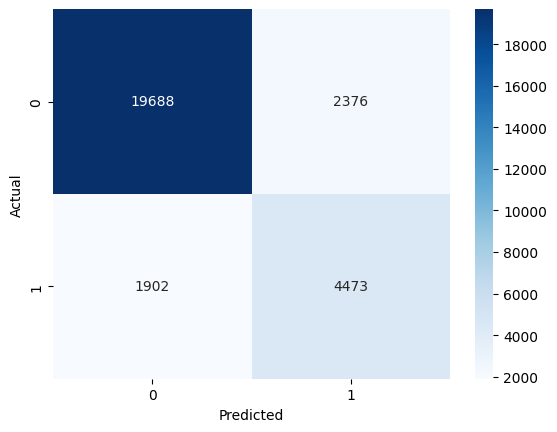

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   9.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.8; total time=  19.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.8; total time=  14.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=4, n_estimators=200, subsample=1.0; total time=   7.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.7; total time=  12.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.7; total time=  12.4s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.7; total time=  11.9s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   8.5s
[CV] 

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# --- 2. Data Cleaning & Preprocessing ---

# Step 2a: Handle the target variable nulls
df.dropna(subset=['CloudBurstTomorrow'], inplace=True)

# Step 2b: Drop columns with too many missing values
df.drop(columns=['Sunshine', 'Evaporation', 'Cloud3pm', 'Cloud9am'], inplace=True)

# Step 2c: Convert binary 'Yes'/'No' columns to 1/0
df['CloudBurstTomorrow'] = df['CloudBurstTomorrow'].map({'No': 0, 'Yes': 1})
if 'CloudBurst Today' in df.columns:
    df['CloudBurst Today'] = df['CloudBurst Today'].map({'No': 0, 'Yes': 1})

# Step 2d: Handle 'Date' column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)

# Step 2e: One-Hot Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# --- 3. Prepare Data for Modeling ---

# Step 3a: Separate features (X) and target (y)
X = df.drop('CloudBurstTomorrow', axis=1)
y = df['CloudBurstTomorrow']

# Step 3b: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3c: Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4. Hyperparameter Tuning with RandomizedSearchCV ---

# Step 4a: Define the grid of parameters to search
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 500, 800],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

# Step 4b: Calculate scale_pos_weight for imbalance
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# Step 4c: Create the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Step 4d: Set up the Randomized Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,  # Number of different parameter combinations to try
    cv=3,       # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

# Step 4e: Run the search to find the best model
print("Starting hyperparameter tuning...")
random_search.fit(X_train, y_train)

# --- 5. Evaluate the BEST Model Found ---

# Step 5a: Get the best model from the search
best_model = random_search.best_estimator_
print("\nBest Parameters Found: ", random_search.best_params_)

# Step 5b: Make predictions using the best model
y_pred = best_model.predict(X_test)

# Step 5c: Print the final evaluation reports
print("\nClassification Report for the Best Model:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix for the Best Model:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()